# 6a. Radiation Transport (RT) Solvers

## 6.0 Fundamental concepts and equations

The fundamental equation we will be using and solving is

\begin{equation}\tag{1}
\frac{d I_{\Omega,\nu}(\tau)}{d \tau_{\nu}} = I_{\Omega,\nu}(\tau_{\Omega,\nu}) - S_{\Omega,\nu}(\tau_{\Omega,\nu}) \,,
\end{equation}

where $I_{\Omega,\nu}(\tau)$ is the ___specific radition intensity___ (energy per unit area, time, and frequency interval; e.g. Watt per square meter and Hertz) at frequency $\nu$ in the direction $\Omega$, $S_{\Omega,\nu}(\tau)$ is the corresponding ___source funtion___ (same units), and $d\tau$ is the ___optical deptht increment___

\begin{equation}\tag{2}
d\tau_{\nu} = \rho\kappa_{\nu} ds \,,
\end{equation}

where $ds$ is an length interval along a "ray" of light in the direction $-\Omega$, $\rho$ is the mass density, and $\kappa_{\nu}$ is the ___opacity___ (in area-per-unit-mass) at frequency $\nu$. The sign change for the right hand side of equation (1) comes from counting $\tau$ in the opposite direction from $ds$. This is common f.x. in atmospheres where we put $\tau=0$ at infinity (if we did the same with an optical thick atmosphere we would get in trouble numerically and conceptually).

The Python package `radiation.py`, discussed in `Radiation.ipynb`, can supply source function values. Opacity values are normally given by table lookup (such as the *OPAL project* for stellar interiors), but in this weeks exercise, we will only use simple approximations or constant values.

Note that, by convention, the optical depth is counted in the direction opposite to the direction of propagation, and therefore the absorption of light is represented by a _positive_ term, and the emission of light by a _negative_ term.

Instead of the frequency $\nu$ one can instead use the ___wavelength___

\begin{equation}\tag{3}
\lambda = \frac{c}{\nu}\,.
\end{equation}

Since, in this context, $\Omega$ and $\nu$ are just "indices", which enumerate various cases, we may as well drop them, and write  

\begin{equation}\tag{4}
\frac{d I}{d \tau} = I - S \,,
\end{equation}

## 6.1 The Feautrier formalism

The ___Feautrier method___ is both a technique for solving Eq. (4), which also gives immediate and useful insight into some fundamental properties of the solutions, and therefore we start with that.   The idea is to combine the equations for light going in opposite directions, while counting optical depth always in the same direction.  Writing $I^-$ for the "outgoing" direction (opposite to the direction in which $\tau$ increases) and $I^+$ for the intensity in the "incoming" direction, we have

\begin{equation}\tag{5}
\frac{d I^-}{d \tau} = I^- - S \,,
\end{equation}

\begin{equation}\tag{6}
\frac{d I^+}{d \tau} = -I^+ + S \,,
\end{equation}

Taking the average sum and difference, and defining

\begin{equation}\tag{7}
P = \frac{1}{2} (I^++ I^-) \,,
\end{equation}

\begin{equation}\tag{8}
R = \frac{1}{2} (I^- - I^+) \,,
\end{equation}

we get these equations for $P$ and $R$:

\begin{equation}\tag{9}
\frac{d P}{d\tau} = R \,,
\end{equation}


\begin{equation}\tag{10}
\frac{d R}{d\tau} = P-S \,,
\end{equation}

which may be combined into a 2nd order ("Feautrier") differential equation for $P$:

\begin{equation}\tag{11}
\frac{d^2 P}{d\tau^2} = P-S \,.
\end{equation}

Since we are often more interested in the _net_ difference between the intensity and the source function, it may also be useful to make the definition

\begin{equation}\tag{12}
Q = P-S \,,
\end{equation}

which when substututed into Eq. 11 yields

\begin{equation}\tag{13}
\frac{d^2 Q}{d\tau^2} = Q -  \frac{d^2 S}{d\tau^2}\,.
\end{equation}

If the _net intensity_, or _heating rate_, $Q$ is systematically smaller than $S$ over an interval of $\tau$, we can immediately deduce a limiting solution,

\begin{equation}\tag{14}
Q =  \frac{d^2 S}{d\tau^2}\,.
\end{equation}

From other arguments (basically just looking at Eq. 11) we understand that $I$ is very close to $S$ at large optical depth, so in such a regimen Eq. 14 is asymtotically accurate, and only requires evaluating a local 2nd derivative of S.

We may also draw another conclusion from Eq. 14; namely, that if we are only interested in the _net intensity_ (which is all we need to compute radiative cooling and heating), then we actually don't need the source function $S$ itself, but only its 2nd order derivative along the line of sight.  And at the boundaries, what we need is apparently only $Q$ (although we may actually get it from knowing both $I$ and $S$).

## 6.2 Solution methods and Python optimization

An essential property of essentially all algorithms for solving the the radiation transport problem (Eq. 11) is that they are fundamentally _recursive_:  To get the solution at one point along a ray, one needs to know the solution at the previous ("upstream") point.  This necessitates writing algorithms as loops, which as know is potentially enormously much slower than when array expressions may be used.

However, we also know that we always have to make a large number of independent solutions; e.g. for a large number of parallel rays, or for rays in different directions $\Omega$, or for solutions for different frequencies along the sam rays.  So, as long as we can write a solver that operates "array-wise" over several solutions at once, there is no negative consequence of having to loop over the direction along the rays.

### 6.2.1  A simple integral solver

Eq. 6 actually has an explicit, simple, and exact analytical solution:

\begin{equation}\tag{15}
  I(\tau_{i+1}) = I(\tau_i) \, e^{-(\tau_{i+1}-\tau_i)} + 
  \int_{\tau_i}^{\tau_{i+1}} S(\tau') \, e^{-(\tau'-\tau_i)} \,\, d\tau' \,,
\end{equation}

which also has the simple interpretation:  The intensity at the next point is the previous intensity attenuated by an exponential optical depth factor, plus the contributions from the source function over the interval, likwise attenuated with the same type of factor.

If we assume that the source funtion $S(\tau)$ is linear, then there is an exact solution; 

\begin{equation}\tag{16}
  I_{i} = I_{i-1}\, e_1 + S_i \, e_2 + S'_{i-1/2}\Delta\tau_{i-1/2}\, e_3 \,,
\end{equation}

where $S'_{i-1/2}(\tau)$ is the 1st derivative of $S(\tau)$ between $S_{i-1}$ and $S_{i}$, $\Delta\tau_{i-1/2}=\tau_i - \tau_{i-1}$, and 

\begin{align}
  e_1 &= 𝑒^{−\Delta\tau_{i-1/2}}\,,\\  \tag{17}
  e_2 &= 1-e_1\,,\\ 
  e_3 &= e_1 - e_2/\Delta\tau_{i-1/2} \,, 
\end{align}

or, since $S'_{i-1/2} = (S_i - S_{i-1})/\Delta\tau_{i-1/2}$, 


\begin{equation}\tag{18}
  I_{i} = I_{i-1}\, e_1 + S_{i-1}\, e_4 + S_{i}\, e_5 \,,
\end{equation}

where

\begin{align}
  e_4 &= -e_3 \,,\\  \tag{19}
  e_5 &= e_2 + e_3 \,,
\end{align}

#### __An important "rule of thumb":__

An interesting corollary is that, since when $\Delta\tau \rightarrow \infty$, then $e_1 \rightarrow 0$, the asymptotic solution becomes 

\begin{equation}\tag{20}
  I(\tau_{i}) \rightarrow S(\tau_i) - S'(\tau_{i}) \,,
\end{equation}

which also may be written, more generally (still assuming a linear $S(\tau)$)

\begin{equation}\tag{21}
  I(\tau) \rightarrow S(\tau-1) \,,
\end{equation}

So, the radiation intensity is approximately equal to ___the source function at one optical depth distance "upstream"___ (= where the light is coming from).  This is a good approximation not only when the source function is linear, but may also be seen as the result of the weighted average in Eq. (15)

### Python code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

A python code with the 1st order integral solver may thus be written as follows. It is important to realise we have to make a choice of staggering for `dtau`. I have chosen to make it upstaggered, such that `dtau[i-1]`$=\Delta \tau_{i-1/2}$. We allow for solving either from left to right (incoming) or from right to left (outgoing):

In [2]:
def integral_1st (S, dtau, Left=None, Right=None):
    I = np.zeros_like(S)
    # Forward solution, from the left to the right boundary (I+ direction, increasing tau)
    if type(Left) != type(None):
        I[0] = Left
        for i in range(1,S.shape[0]): # We assume I[0] is given or zero
            e1 = np.exp(-dtau[i-1])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i-1]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i-1] + e4*S[i-1] + e5*S[i]
    # Reverse solution, from the right to the left boundary (I- direction, decreasing tau)
    elif type(Right) != type(None): 
        I[-1] = Right
        for i in range(S.shape[0]-2,-1,-1): # We assume I[-1] is given or zero
            e1 = np.exp(-dtau[i])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i+1] + e4*S[i+1] + e5*S[i]
    else:
        print('ERROR: Either the Ileft or Iright boundary condition must be given !')
    return I

__NOTE:__ The shapes of `S` and `dtau` can be anything from just  1-D arrays `(n)` to multidimensional arrays`(n,m1,m2,m3,...)`!  The only requirement is that the direction of propagation should be in the first index.  One may use the `.transpose()` array method to reorder.

### Testing the solver on a case with known solution

A simpe linear source function is

\begin{equation}\tag{22}
  S(\tau) = A + B \tau \,,
\end{equation}


### __Task 1: Construct a test__ (10 p)

Use pen and paper (or overkill with a symbolic code) to solve Eq. (5) and Eq. (6) with the source function Eq. (22), and use the solution to test the 1st order solver (or to test your test ;-):

In [3]:
import sympy
A, B, tau = sympy.symbols("A, B, tau")
I = sympy.Function("I")
S = A + B * tau

In [4]:
equation = sympy.Eq(I(tau).diff(tau),I(tau)-S)
sympy.dsolve(equation, I(tau))

Eq(I(tau), (C1 + (A + B*tau + B)*exp(-tau))*exp(tau))

In [5]:
equation = sympy.Eq(I(tau).diff(tau),-I(tau)+S)
sympy.dsolve(equation, I(tau))

Eq(I(tau), (C1 + (A + B*tau - B)*exp(tau))*exp(-tau))

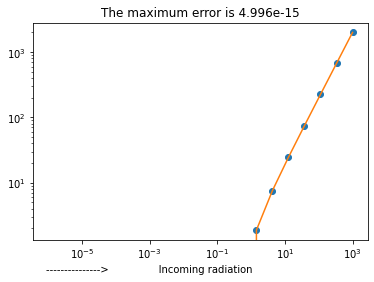

In [6]:
def Iplus_1st(tau,A,B):
    """ Intentionally the wrong exact solution; REPLACE WITH CORRECT SOLUTION """
    return (A+B*tau-B)

def plus_test(n=20,A=0.5,B=2,solver=integral_1st):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iplus_1st(tau,A,B)
    I = integral_1st (S, dtau, Left=I_exact[0])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('--------------->                Incoming radiation                                 ');

plus_test(A=1,B=2,solver=integral_1st)

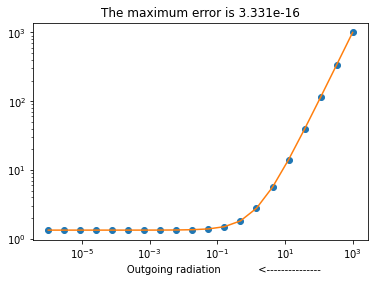

In [7]:
def Iminus_1st(tau,A,B):
    return (A+B*tau+B)

def minus_test(n=20,A=0.5,B=2):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iminus_1st(tau,A,B)
    I = integral_1st (S, dtau, Right=I_exact[-1])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('               Outgoing radiation            <---------------');
    
minus_test(B=1,A=0.33)

### Task 2: Stars behind a BE sphere (30p)

Given your radiative transfer solver, imagine that you place for example 100 stars behind a Bonnor-Ebert sphere. Assume that the BE-sphere has a mass of 1 solar mass and a temperature of 10 K (which means the BE-radius is about 10,000 AU), and assume an opacity $\kappa = 1$ cm$^2$ per gram.  Then compute the intensity of the light that comes through, and make a nice image! Try at other wavelengths, use that $\kappa \propto \kappa_0 / \lambda$ is a good approximation, and that the above opacity corresponds to a wavelength of roughly 1 mm.

Use the ```BE_sphere.py``` to set up you core; you can see how it is used in ```BE_sphere.ipynb```.

It's OK to place the stars in a 10x10 pattern, but it of course looks nicer to place the stars randomly (and to use more than 100 of them)!

Comment on the results; does it makes sense; how does it compare to the famous B68?

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from BE_sphere import BE_sphere
from scaling   import scaling, CGS
from HD        import HD

class BE_experiment(HD):
    def __init__(u, units, verbose=0,gamma=1.0001, **kwargs):
        HD.__init__(u,gamma=gamma,**kwargs)
        u.units = units
        BE_sphere(u, verbose=verbose,gamma=gamma)

# This sets numerical units such that 1 length = 1e4 AU, 1 velocity = 1 km/s, 1 mass = 1 solar mass
units = scaling (l=1e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=0)
u = BE_experiment (units, n=100, gamma=1.01, verbose=0)

BE_sphere: gamma,T_K= 1.01 10.0


Make background intensity (initial condition

In [9]:
nstars = 500

x,y = np.random.rand(2,nstars)*np.array(u.n)[1:,None] #probability uniform across the sky
radius = 0.2/np.random.power(3, nstars) # probability of distance \propto r^2 => r\propto 1/r^2
x_grid, y_grid = np.mgrid[0:u.n[1], 0:u.n[2]]
xdiff = (x[:, None,None]-x_grid[None,:,:,])
ydiff = (y[:, None,None]-y_grid[None,:,:,])
nradiusses = np.hypot(xdiff,ydiff)/radius[:,None,None]
background = np.sum(np.tanh((1-nradiusses)*10)/2+1/2,0) # make soft edge on stars
background = np.clip(background,0,1) # cap to make drawing prettier

In [10]:
def calc_at_wavelengt(factor):
    kappa = factor
    ds = u.ds*u.units.l*u.n[0]
    rho = u.D*u.units.D
    dtau = (rho*kappa*ds)
    return integral_1st (np.zeros_like(dtau), dtau, Left=background)[-1]

To make a nice image, we run the code at 3 different opacities corresponding to 3 different wavelengths. We then show the image using these wavelengths as the RGB channels, with a small dampening to the red channel to make the stars appear slightly blue

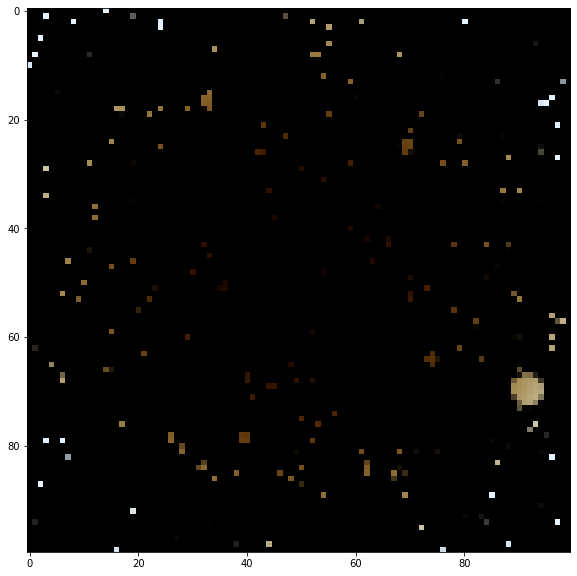

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose([calc_at_wavelengt(0.3)*0.9,calc_at_wavelengt(0.5)*0.95,calc_at_wavelengt(1)],[1,2,0]))

### 6.2.2  A better integral solver

The simple 1st order integral solver above may be sufficient for some purposes, such as diagnostics of light from a radiating body.  It requires only that one evaluates one exponential, one divide, two mulitiplications, and three add/subtract, to compute the three $e$-coefficients that enter into Eq. (18).

However, already in Eq. (13) we learnt that, for accurate work (e.g. when computing heating and cooling) the 2nd derivative of $S$ is important, and hence assuming a linear source function is not enough.  But we can use the results in Eqs. (17-19) to get the more accurate solution with no further derivation, by defining 

\begin{align}
  Q^+ = I^+ - S \,,  \\
  Q^- = I^- - S \,, \tag{23} 
\end{align}


which leads to 

\begin{align}
\frac{d Q^+}{d \tau} = - Q^+ - \frac{d S}{d\tau} =   - Q^+ - S' \,, \\
\frac{d Q^-}{d \tau} = + Q^- - \frac{d S}{d\tau} =   + Q^- - S' \,. \tag{24} 
\end{align}

These are equations with exactly the same form as Eqs. (5-6), only with $Q^\pm$ instead of $I^\pm$, and $S'$ or $-S'$ instead of $S$, and hence for a linear S' (a quadratic S) they have the solutions like (cf. Eq. 16):

\begin{equation}
  Q_{i}^+ = Q_{i-1}^+\, e_1 - S'_{i}\, e_2 - S''_{i}\,\Delta\tau_{i-1/2} \, e_3 \,. \tag{25}
\end{equation}

By expressing the 1st and second derivatives as finite differences, one can write for example, now with 2nd order accuracy in $S(\tau)$:

\begin{equation}\tag{26}
  Q_{i}^+ = Q_{i-1}^+\, e_1 + S_{i-1}\, e_6 + S_{i}\, e_7 + S_{i+1}\, e_8 \,.
\end{equation}

#### __Bonus Task: Compute the coefficients needed in the accurate integral RT solver__ (20 p)

Derive, using pen and paper (or symbolic Python, or Mathematic or Maple), expression for $e_{6,7,8}$. You will need them below, so be careful, and double check against a known solution! Start out by computing the first and second derivatives of the source function centered on point $i$ from


\begin{equation}\tag{27}
  S'_i = \frac{\Delta\tau_{i-1/2} S'_{i+1/2} + \Delta\tau_{i+1/2} S'_{i-1/2}}{(\Delta\tau_{i-1}+\Delta\tau_i)}
\end{equation}

\begin{equation}\tag{28}
  S''_i = \frac{S'_{i+1/2} - S'_{i-1/2} }{{1 \over 2}(\Delta\tau_{i-1}+\Delta\tau_i)}
\end{equation}

__NOTE:__ both $S'_i$ and $S''_i$ are centered on the same point as $I_i$, $S_i$, and $\tau_i$.

__NOTE:__ It may not be the best and simplest approach to compute long and complicated expression for each of e6, e7, and e8.  They contain common expression, stemming from the implementation of Eqs. 26-27, so computing intermediate expression may actually give fewer operations, and hence faster code!

__PRIZE:__ If you implement the solver, there are 20 extra points, if it is faster than one of my solvers! The test will be made with the `timeit` procedure below, on ERDA, repeating a few times to get a stable average. Naturally, _the code only qualifies to participate if the result is exact_ for a 2nd order source function!

### Python code:

A python code with the accurate integral solver may be written as follows (you need to import your own e6-e8 coefficients and make two cases; one for Q+ another for Q- !):

In [12]:
conda install -c numba icc_rt -S

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda/envs/python3

  added / updated specs:
    - icc_rt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asttokens-2.0.5            |     pyhd8ed1ab_0          21 KB  conda-forge
    black-21.12b0              |     pyhd8ed1ab_0         122 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py38h578d9bd_1         145 KB  conda-forge
    click-8.0.3                |   py38h578d9bd_1         146 KB  conda-forge
    dataclasses-0.8            |     pyhc8e2a94_3          10 KB  conda-forge
    decorator-5.1.1            |     pyhd8ed1ab_0          12 KB  conda-forge
    

In [13]:
import numba
@numba.njit(fastmath=True, parallel=False)
def Q_integral_2nd_32_inner (S0, dtau0, Initial):
    S = S0.astype(np.float32)
    dtau = dtau0.astype(np.float32)
    Q = np.empty(S.shape, dtype=np.float32)
    Q[0] = Initial.astype(np.float32)
    for j in numba.prange(S.shape[1]): 
        for k in range(S.shape[2]):
            right_grad = (S[1, j, k] - S[0, j, k])/dtau[0, j, k]
            for i in range(1,S.shape[0]-1):
                e1 = np.exp(-dtau[i-1, j, k])
                e2 = np.float32(1) - e1
                e3 = e1 - e2/dtau[i-1, j, k]
                
                left_grad = right_grad
                right_grad = (S[i+1, j, k] - S[i, j, k])/dtau[i, j, k]
                inv_tau_sum = np.float32(1) / dtau[i, j, k]+dtau[i-1, j, k]
                mean_grad = (left_grad*dtau[i, j, k]+right_grad*dtau[i-1, j, k]) * inv_tau_sum
                double_diff = np.float32(2)*(right_grad-left_grad)   * inv_tau_sum

                Q[i,j,k] = e1*Q[i-1, j, k] + e2*mean_grad + double_diff * dtau[-1, j, k] * e3
                #x0 = np.float32(1)/(dtau[i-1, j, k]+dtau[i, j, k])
                #x2 = x1 # reuse calc, right before is now left
                #x1 = (S[i+1, j, k] - S[i, j, k])/dtau[i, j, k]

                #Q[i, j, k] = e1*Q[i-1, j, k] + x0*(e2*(x1*dtau[i-1, j, k] + x2*dtau[i, j, k]) - np.float32(2)*e3*(x1-x2)*dtau[i-1, j, k])
    return Q
"""
def Q_integral_2nd_32_inner (S, dtau, Initial):
    Q = np.empty(S.shape)
    Q[0] = Initial
    for i in range(1,S.shape[0]-1):
        e1 = np.exp(-dtau[i-1])
        e2 = np.float32(1) - e1
        e3 = e1 - e2/dtau[i-1]

        a = 1/(dtau[i-1]+dtau[i])
        b = dtau[i]/dtau[i-1]
        c = e2 + 2*e3
        
        e6 = -(e2*b-2*e3)*a
        e7 = e2/dtau[i-1] - c/dtau[i]
        e8 = c*a/b

        Q[i] = e1*Q[i-1] + e6*S[i-1] + e7*S[i] + e8*S[i+1]
    return Q"""

def Q_integral_2nd (S, dtau, Left=None, Right=None):
    def expand_dims(a, dims): 
        return np.expand_dims(a, list(range(a.ndim, dims)))
    # Forward solution, from the left to the right boundary (I+ direction, increasing tau)
    if type(Left) != type(None):
        return Q_integral_2nd_32_inner(expand_dims(S,3), expand_dims(dtau,3), expand_dims(Left,2)).reshape(S.shape)
    elif type(Right) != type(None): 
        return Q_integral_2nd_32_inner(expand_dims(S[::-1],3), expand_dims(np.roll(dtau[::-1],-1,0),3), expand_dims(Right,2))[::-1].reshape(S.shape)
    else:
        print('ERROR: Either the Ileft or Iright boundary condition must be given !')
    return I

For reasons unknown -- but presumably because the virtual machine does not get full attention -- the time for a solution varies signficantly, but typically has a well defined bottom, showing up at least some time during 40 attempts.

In [14]:
def timeit(solver,duration=10):
    n = 200
    S = np.ones((n,n,n))
    dtau = np.ones((n,n,n))
    Q0 = np.ones((n,n))    
    def test(solver):
        t = time()
        Q = solver (S, dtau, Left=Q0)
        used = time()-t
        return 1e9*used/n**3
    start = time()
    worst = test(solver)
    best = worst
    used = time()-start
    while used < duration:
        ns = test(solver)
        if ns < best:
            best = ns
        if ns > worst:
            worst = ns
        used = time()-start
        plt.plot(used, ns, 'o')
    plt.ylim(0,worst*1.1); plt.xlabel('time'); plt.ylabel('cost')
    print('{}: {:.2f} seconds =>  {:.1f} nanoseconds per point'.format(solver.__name__,used,best))

In [15]:
import sympy
A, B, C, tau = sympy.symbols("A, B, C, tau")
I = sympy.Function("I")
S = A + B * tau + C * tau**2
equation = sympy.Eq(I(tau).diff(tau),I(tau)-S)
sympy.dsolve(equation, I(tau))

Eq(I(tau), (C1 + (A + B*tau + B + C*tau**2 + 2*C*tau + 2*C)*exp(-tau))*exp(tau))

In [16]:
def Qplus(tau,A,B,C):
    """ The correct exact 2nd order S() solution """
    return A+B*tau+B+C*tau**2+2*C*tau+2*C

def Qminus(tau,A,B,C):
    """ The correct exact 2nd order S() solution """
    return A*tau + B + C # wrong!

def Q_test (solver, n=50, A=1., B=1, C=2, plus=True, verbose=0):
    """ Compute the 2nd order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i] + C*tau[i]**2
    S[-1] = A + B*tau[-1] + C*tau[-1]**2
    Q0 = Qplus(tau,A,B,C) if plus else Qminus(tau,A,B,C)
    Q1 = solver (S, dtau,
                 Left=Q0[0] if plus else None,
                 Right=None if plus else Q0[-1]
                )
    error = (Q1-Q0)/S
    if verbose:
        print('Q0',Q0[1:-2])
        print('Q1',Q1[1:-2])
        print('dQ',Q1[1:-2]-Q0[1:-2])
        print('er',error[1:-2])
    plt.semilogx(tau[1:-2], Q0[1:-2], 'o')
    plt.semilogx(tau[1:-2], Q1[1:-2])
    plt.title('{}: max err = {:.3e}'.format(solver.__name__,np.max(np.abs(error[1:-2]))))
    if plus:
        plt.xlabel('--------------->                Incoming radiation                   ');
    else:
        plt.xlabel('<---------------                Outgoing radiation                   ');
    return dtau

np.set_printoptions(linewidth=170, formatter={'float_kind':lambda x: "{:10.3e}".format(x)})

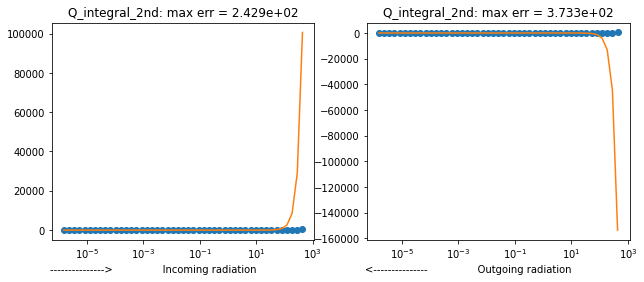

In [17]:
A = 1.0; B = 0.1; C = +0.002
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); Q_test (Q_integral_2nd, A=A, B=B, C=C, plus=1); print('')
plt.subplot(1,3,2); Q_test (Q_integral_2nd, A=A, B=B, C=C, plus=0);

## Absalon Handin:

Copy the solution to task 1, task 2, and possibly the bonus task down here. This gives you a clean reference code above, and makes it easier to see what has been modified.

Submit notebook and pdf of notebook to Absalon

### __Task 1: Construct a test__ (10 p)

Use pen and paper (or overkill with a symbolic code) to solve Eq. (5) and Eq. (6) with the source function Eq. (22), and use the solution to test the 1st order solver (or to test your test ;-):

In [18]:
import sympy
A, B, tau = sympy.symbols("A, B, tau")
I = sympy.Function("I")
S = A + B * tau

In [19]:
equation = sympy.Eq(I(tau).diff(tau),I(tau)-S)
sympy.dsolve(equation, I(tau))

Eq(I(tau), (C1 + (A + B*tau + B)*exp(-tau))*exp(tau))

In [20]:
equation = sympy.Eq(I(tau).diff(tau),-I(tau)+S)
sympy.dsolve(equation, I(tau))

Eq(I(tau), (C1 + (A + B*tau - B)*exp(tau))*exp(-tau))

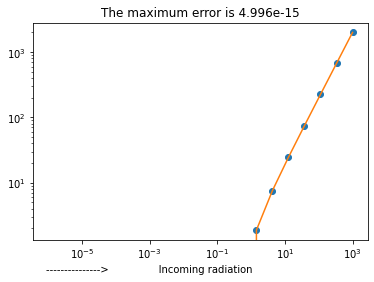

In [21]:
def Iplus_1st(tau,A,B):
    """ Intentionally the wrong exact solution; REPLACE WITH CORRECT SOLUTION """
    return (A+B*tau-B)

def plus_test(n=20,A=0.5,B=2,solver=integral_1st):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iplus_1st(tau,A,B)
    I = integral_1st (S, dtau, Left=I_exact[0])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('--------------->                Incoming radiation                                 ');

plus_test(A=1,B=2,solver=integral_1st)

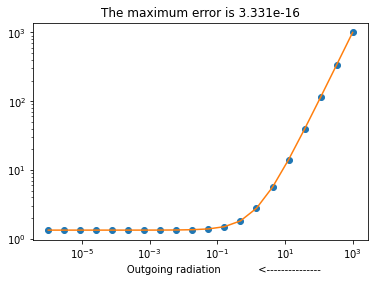

In [22]:
def Iminus_1st(tau,A,B):
    return (A+B*tau+B)

def minus_test(n=20,A=0.5,B=2):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iminus_1st(tau,A,B)
    I = integral_1st (S, dtau, Right=I_exact[-1])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('               Outgoing radiation            <---------------');
    
minus_test(B=1,A=0.33)

### Task 2: Stars behind a BE sphere (30p)

Given your radiative transfer solver, imagine that you place for example 100 stars behind a Bonnor-Ebert sphere. Assume that the BE-sphere has a mass of 1 solar mass and a temperature of 10 K (which means the BE-radius is about 10,000 AU), and assume an opacity $\kappa = 1$ cm$^2$ per gram.  Then compute the intensity of the light that comes through, and make a nice image! Try at other wavelengths, use that $\kappa \propto \kappa_0 / \lambda$ is a good approximation, and that the above opacity corresponds to a wavelength of roughly 1 mm.

Use the ```BE_sphere.py``` to set up you core; you can see how it is used in ```BE_sphere.ipynb```.

It's OK to place the stars in a 10x10 pattern, but it of course looks nicer to place the stars randomly (and to use more than 100 of them)!

Comment on the results; does it makes sense; how does it compare to the famous B68?

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from BE_sphere import BE_sphere
from scaling   import scaling, CGS
from HD        import HD

class BE_experiment(HD):
    def __init__(u, units, verbose=0,gamma=1.0001, **kwargs):
        HD.__init__(u,gamma=gamma,**kwargs)
        u.units = units
        BE_sphere(u, verbose=verbose,gamma=gamma)

# This sets numerical units such that 1 length = 1e4 AU, 1 velocity = 1 km/s, 1 mass = 1 solar mass
units = scaling (l=1e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=0)
u = BE_experiment (units, n=100, gamma=1.01, verbose=0)

BE_sphere: gamma,T_K= 1.01 10.0


Make background intensity (initial condition

In [24]:
nstars = 500

x,y = np.random.rand(2,nstars)*np.array(u.n)[1:,None] #probability uniform across the sky
radius = 0.2/np.random.power(3, nstars) # probability of distance \propto r^2 => r\propto 1/r^2
x_grid, y_grid = np.mgrid[0:u.n[1], 0:u.n[2]]
xdiff = (x[:, None,None]-x_grid[None,:,:,])
ydiff = (y[:, None,None]-y_grid[None,:,:,])
nradiusses = np.hypot(xdiff,ydiff)/radius[:,None,None]
background = np.sum(np.tanh((1-nradiusses)*10)/2+1/2,0) # make soft edge on stars
background = np.clip(background,0,1) # cap to make drawing prettier

In [25]:
def calc_at_wavelengt(factor):
    kappa = factor
    ds = u.ds*u.units.l*u.n[0]
    rho = u.D*u.units.D
    dtau = (rho*kappa*ds)
    return integral_1st (np.zeros_like(dtau), dtau, Left=background)[-1]

To make a nice image, we run the code at 3 different opacities corresponding to 3 different wavelengths. We then show the image using these wavelengths as the RGB channels, with a small dampening to the red channel to make the stars appear slightly blue

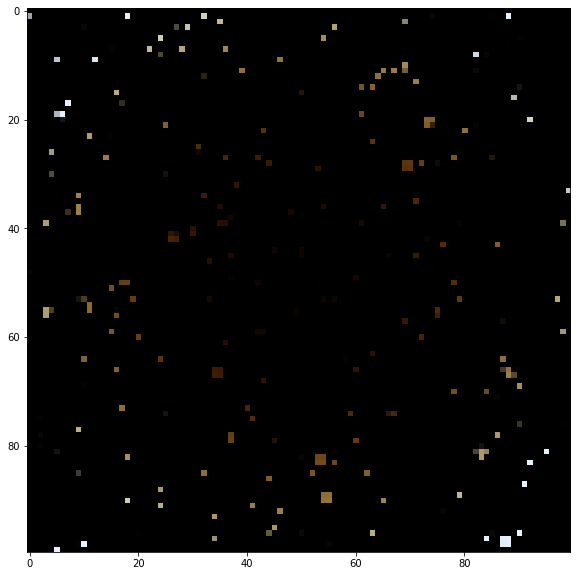

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose([calc_at_wavelengt(0.3)*0.9,calc_at_wavelengt(0.5)*0.95,calc_at_wavelengt(1)],[1,2,0]))

# Task 3:

After A LONG time of debugging, I have given up making this thing work. But here is the sympy code for calculating the expression, as well as for extracting the coeficiencts e6, e7 and e8: 

In [27]:
import sympy
S = sympy.IndexedBase("S")
dS = sympy.IndexedBase("dS")
dtau = sympy.IndexedBase(r"\Delta \tau")
half = sympy.Rational(1,2)
dtauSum = lambda i: dtau[i+half] + dtau[i-half]# sympy.IndexedBase(r"\Sigma \Delta \tau")
i = sympy.symbols("i")
Q, e1, e2, e3 = sympy.symbols("Q, e1, e2, e3")
#e1 = sympy.exp(-dtau[i-half])
#e2 = 1-e1
#e3 = e1-e2/dtaAAAAAu[i-half]

edgeDiff = lambda i: (S[i+half]-S[i-half])/dtau[i]
centerDiff = (dtau[i-half]*edgeDiff(i+half)+dtau[i+half]*edgeDiff(i-half))/dtauSum(i)
center2Diff = 2*(edgeDiff(i+half)-edgeDiff(i-half))/dtauSum(i)
expr = Q*e1+centerDiff*e2+center2Diff*dtau[i-half]*e3

In [28]:
expr

Q*e1 + e2*((S[i + 1] - S[i])*\Delta \tau[i - 1/2]/\Delta \tau[i + 1/2] + (-S[i - 1] + S[i])*\Delta \tau[i + 1/2]/\Delta \tau[i - 1/2])/(\Delta \tau[i + 1/2] + \Delta \tau[i - 1/2]) + e3*(2*(S[i + 1] - S[i])/\Delta \tau[i + 1/2] - 2*(-S[i - 1] + S[i])/\Delta \tau[i - 1/2])*\Delta \tau[i - 1/2]/(\Delta \tau[i + 1/2] + \Delta \tau[i - 1/2])

In [29]:
expr.diff(S[i-1]).simplify()

(-e2*\Delta \tau[i + 1/2] + 2*e3*\Delta \tau[i - 1/2])/((\Delta \tau[i + 1/2] + \Delta \tau[i - 1/2])*\Delta \tau[i - 1/2])

In [30]:
expr.diff(S[i]).simplify()

e2/\Delta \tau[i - 1/2] - e2/\Delta \tau[i + 1/2] - 2*e3/\Delta \tau[i + 1/2]

In [31]:
expr.diff(S[i+1]).simplify()

(e2 + 2*e3)*\Delta \tau[i - 1/2]/((\Delta \tau[i + 1/2] + \Delta \tau[i - 1/2])*\Delta \tau[i + 1/2])

You can see how i have implemented it in two ways: Both by combining "logically meaningfull" subexpressions like "left gradient", "right gradient" etc, and by using the coefficients calculated above. Unfortunately, it doesn't matter, because it doesn't work... :(

i was gonna write a bit about how transposing the iteration space and installing the intel short vector library allows all calculations to be performed on data residing in the registers which maximixe the performance, but with a disfunctional code this seems a bit useless

In [32]:
import numba
@numba.njit(fastmath=True, parallel=True)
def Q_integral_2nd_32_inner (S0, dtau0, Initial):
    S = S0.astype(np.float32)
    dtau = dtau0.astype(np.float32)
    Q = np.empty(S.shape, dtype=np.float32)
    Q[0] = Initial.astype(np.float32)
    for j in numba.prange(S.shape[1]): 
        for k in range(S.shape[2]):
            right_grad = (S[1, j, k] - S[0, j, k])/dtau[0, j, k]
            for i in range(1,S.shape[0]-1):
                e1 = np.exp(-dtau[i-1, j, k])
                e2 = np.float32(1) - e1
                e3 = e1 - e2/dtau[i-1, j, k]
                
                left_grad = right_grad
                right_grad = (S[i+1, j, k] - S[i, j, k])/dtau[i, j, k]
                inv_tau_sum = np.float32(1) / dtau[i, j, k]+dtau[i-1, j, k]
                mean_grad = (left_grad*dtau[i, j, k]+right_grad*dtau[i-1, j, k]) * inv_tau_sum
                double_diff = np.float32(2)*(right_grad-left_grad)   * inv_tau_sum

                Q[i,j,k] = e1*Q[i-1, j, k] + e2*mean_grad + double_diff * dtau[-1, j, k] * e3
                #x0 = np.float32(1)/(dtau[i-1, j, k]+dtau[i, j, k])
                #x2 = x1 # reuse calc, right before is now left
                #x1 = (S[i+1, j, k] - S[i, j, k])/dtau[i, j, k]

                #Q[i, j, k] = e1*Q[i-1, j, k] + x0*(e2*(x1*dtau[i-1, j, k] + x2*dtau[i, j, k]) - np.float32(2)*e3*(x1-x2)*dtau[i-1, j, k])
    return Q
"""
def Q_integral_2nd_32_inner (S, dtau, Initial):
    Q = np.empty(S.shape)
    Q[0] = Initial
    for i in range(1,S.shape[0]-1):
        e1 = np.exp(-dtau[i-1])
        e2 = np.float32(1) - e1
        e3 = e1 - e2/dtau[i-1]

        a = 1/(dtau[i-1]+dtau[i])
        b = dtau[i]/dtau[i-1]
        c = e2 + 2*e3
        
        e6 = -(e2*b-2*e3)*a
        e7 = e2/dtau[i-1] - c/dtau[i]
        e8 = c*a/b

        Q[i] = e1*Q[i-1] + e6*S[i-1] + e7*S[i] + e8*S[i+1]
    return Q"""

def Q_integral_2nd (S, dtau, Left=None, Right=None):
    def expand_dims(a, dims): 
        return np.expand_dims(a, list(range(a.ndim, dims)))
    # Forward solution, from the left to the right boundary (I+ direction, increasing tau)
    if type(Left) != type(None):
        return Q_integral_2nd_32_inner(expand_dims(S,3), expand_dims(dtau,3), expand_dims(Left,2)).reshape(S.shape)
    elif type(Right) != type(None): 
        return Q_integral_2nd_32_inner(expand_dims(S[::-1],3), expand_dims(np.roll(dtau[::-1],-1,0),3), expand_dims(Right,2))[::-1].reshape(S.shape)
    else:
        print('ERROR: Either the Ileft or Iright boundary condition must be given !')
    return I

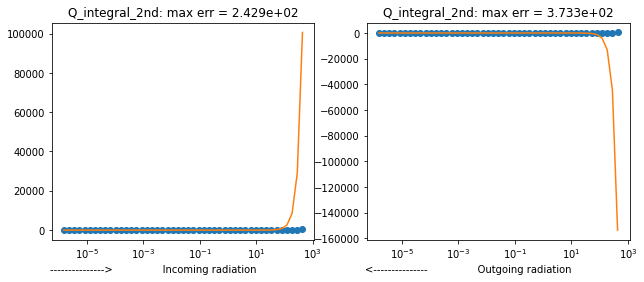

In [33]:
A = 1.0; B = 0.1; C = +0.002
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); Q_test (Q_integral_2nd, A=A, B=B, C=C, plus=1); print('')
plt.subplot(1,3,2); Q_test (Q_integral_2nd, A=A, B=B, C=C, plus=0);

integral_1st: 10.01 seconds =>  25.3 nanoseconds per point


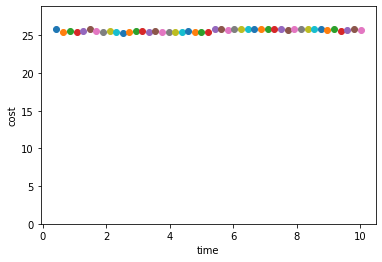

In [34]:
timeit(integral_1st)

Q_integral_2nd: 10.36 seconds =>  24.5 nanoseconds per point


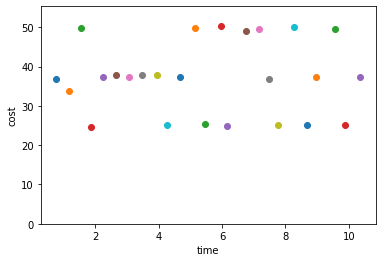

In [35]:
timeit(Q_integral_2nd)